In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

In [2]:
test_data = pd.read_csv('/home/sshamsi/Projects/astrobio_tutorials/t4_exoplanets_ml/exoTest.csv').fillna(0)
train_data = pd.read_csv('/home/sshamsi/Projects/astrobio_tutorials/t4_exoplanets_ml/exoTrain.csv').fillna(0)

In [3]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [4]:
#Reduce memory
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)')

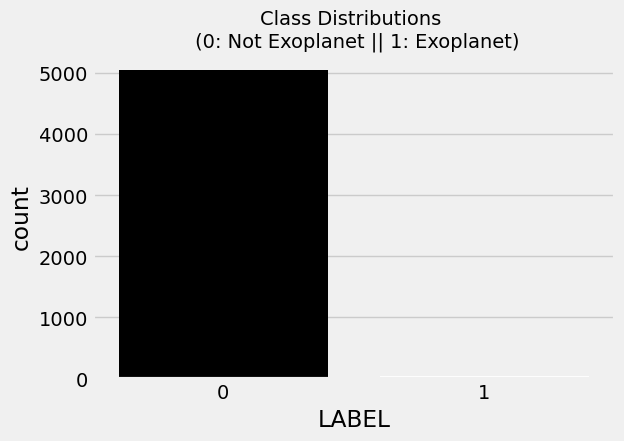

In [6]:
#Visualization:
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)

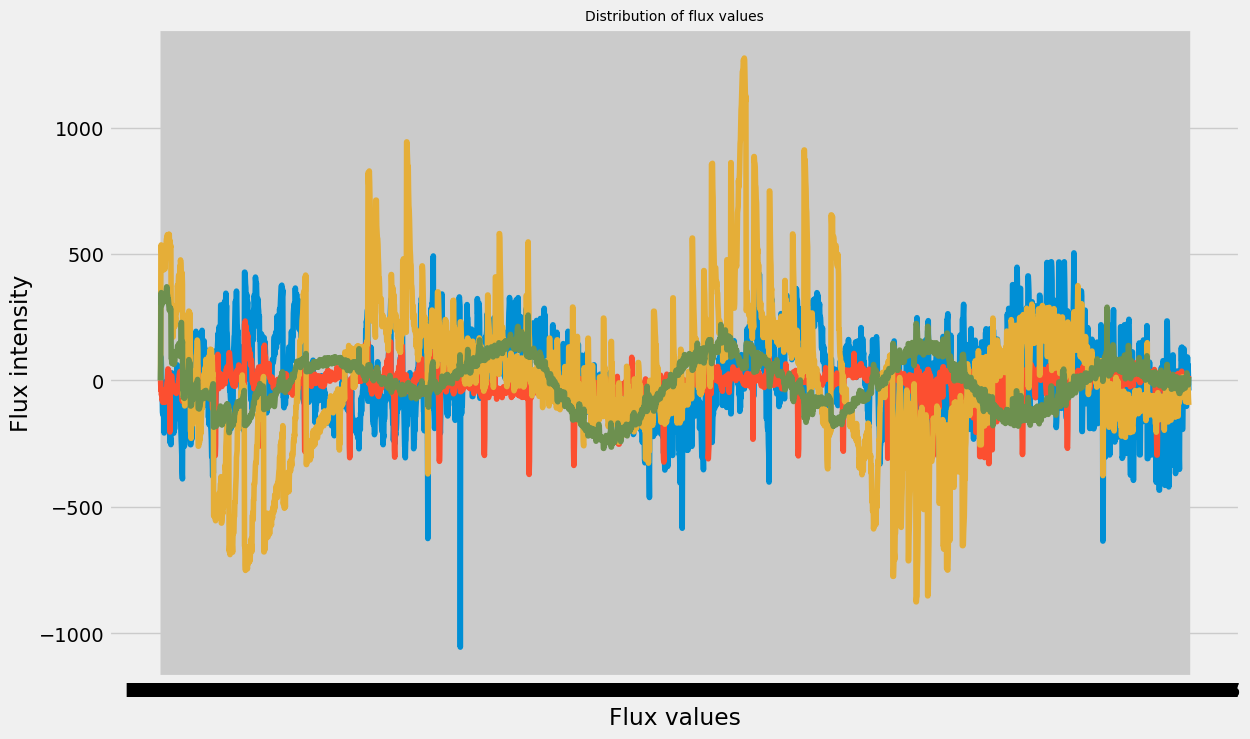

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

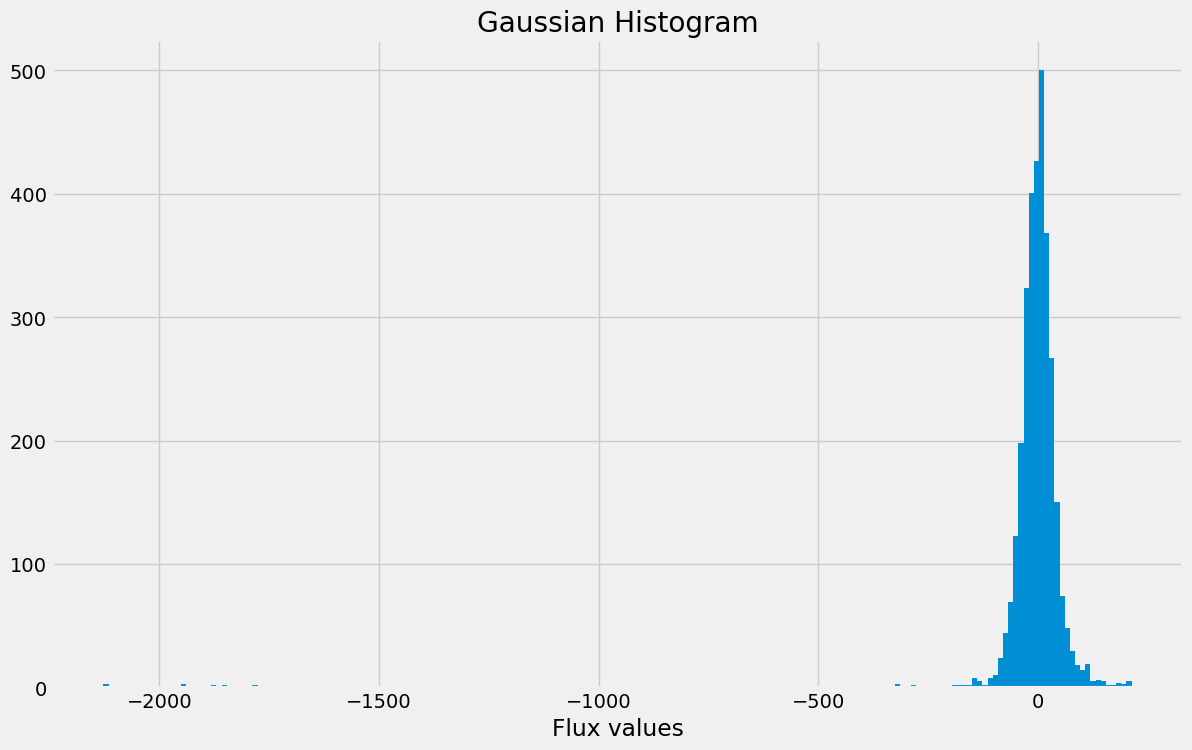

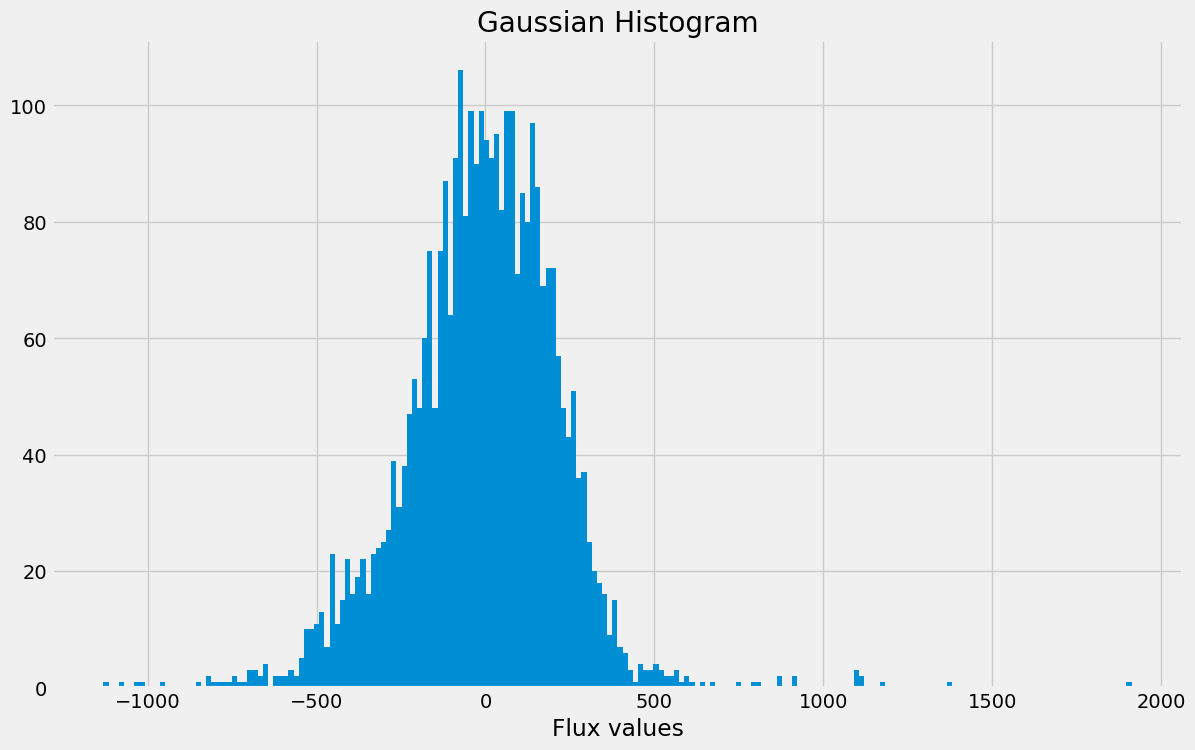

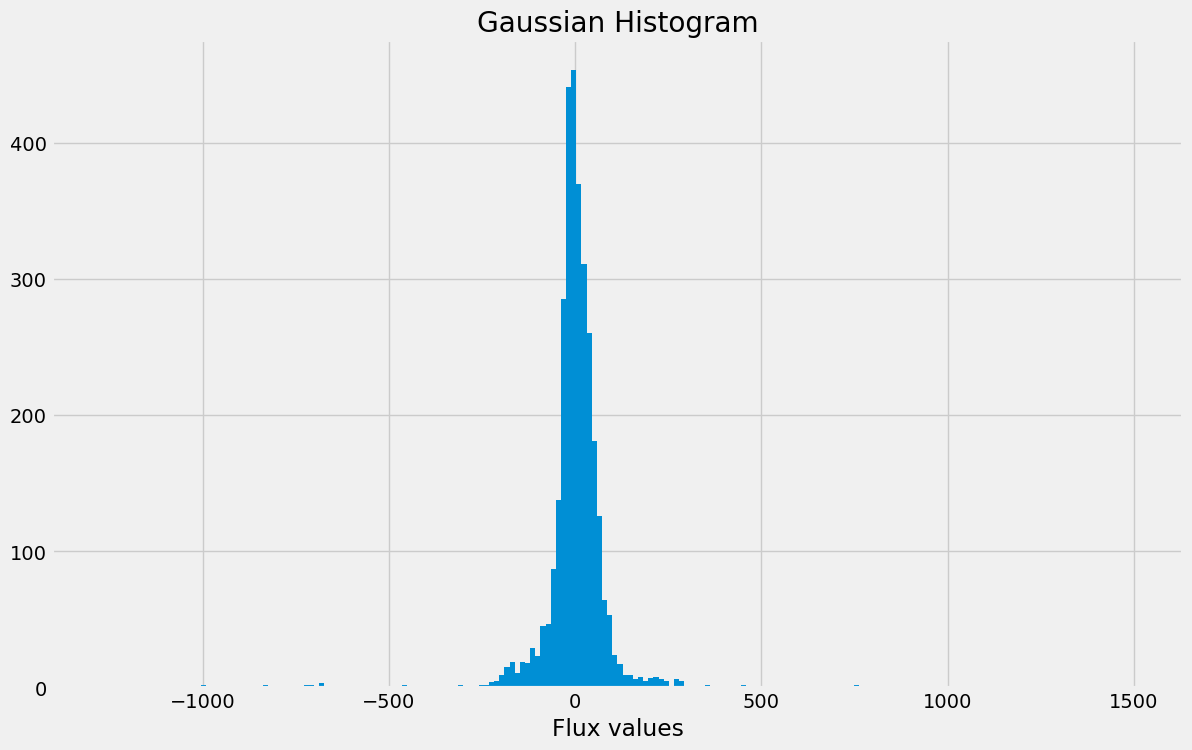

In [8]:
#Gaussian histogram of no exoplanets
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

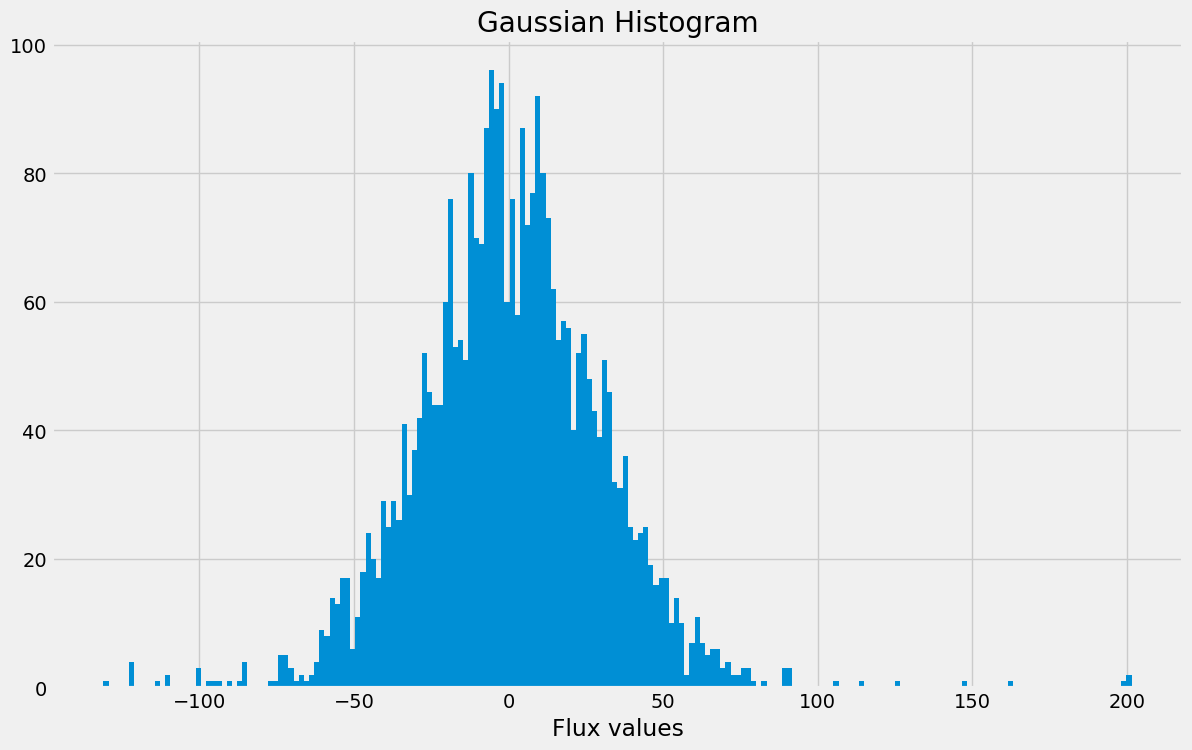

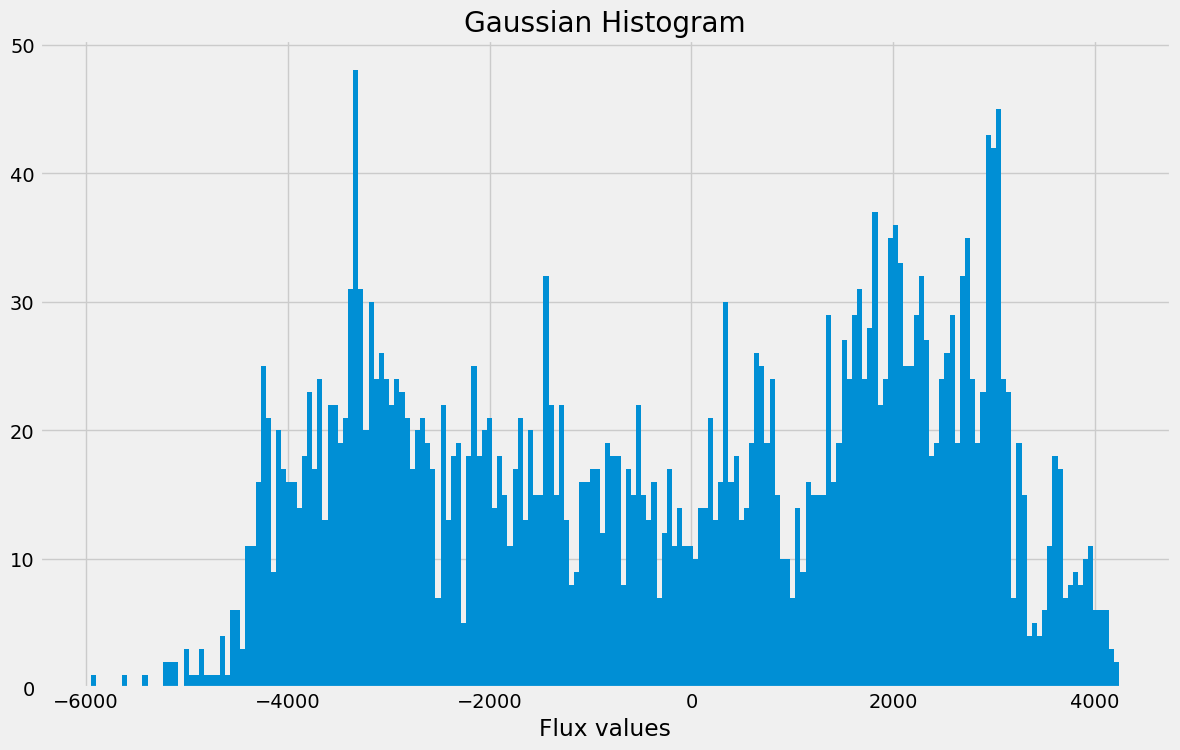

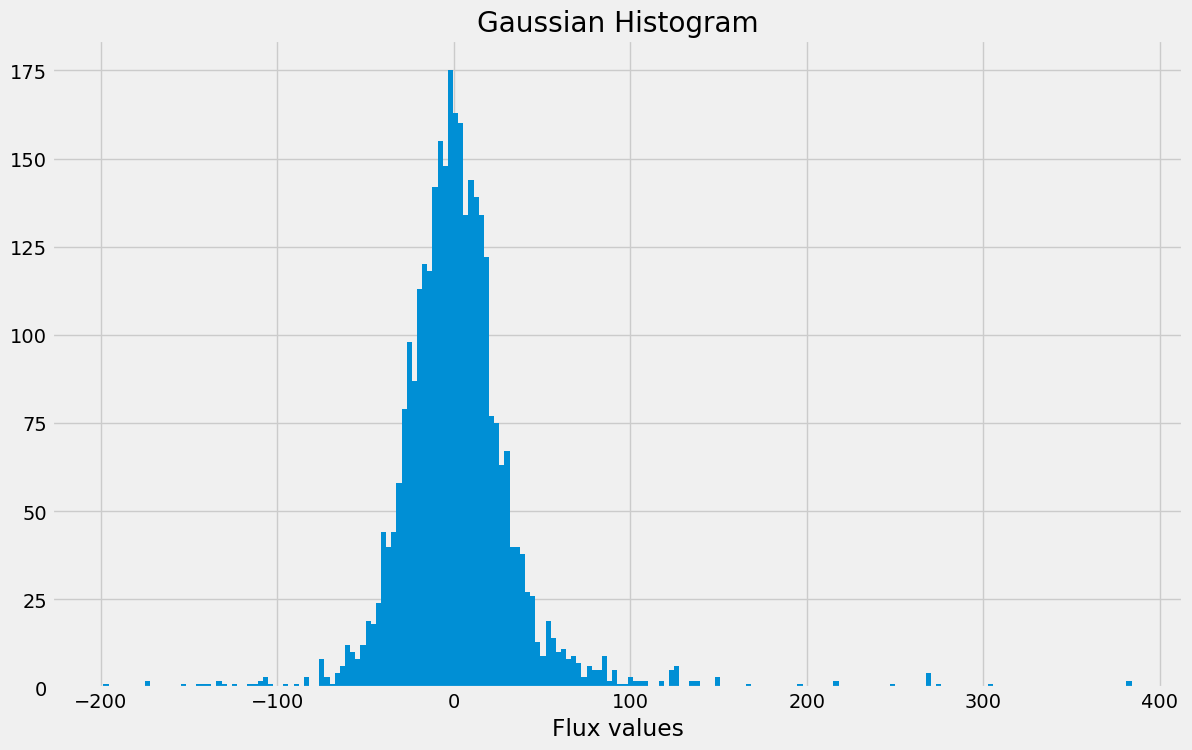

In [9]:
#Gaussian histogram of exoplanets
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

In [10]:
#splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

In [11]:
#Normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

In [12]:
#Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

In [13]:
#Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

In [14]:
#Dimentioanlity reduction
from sklearn.decomposition import PCA
pca = PCA() 
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1

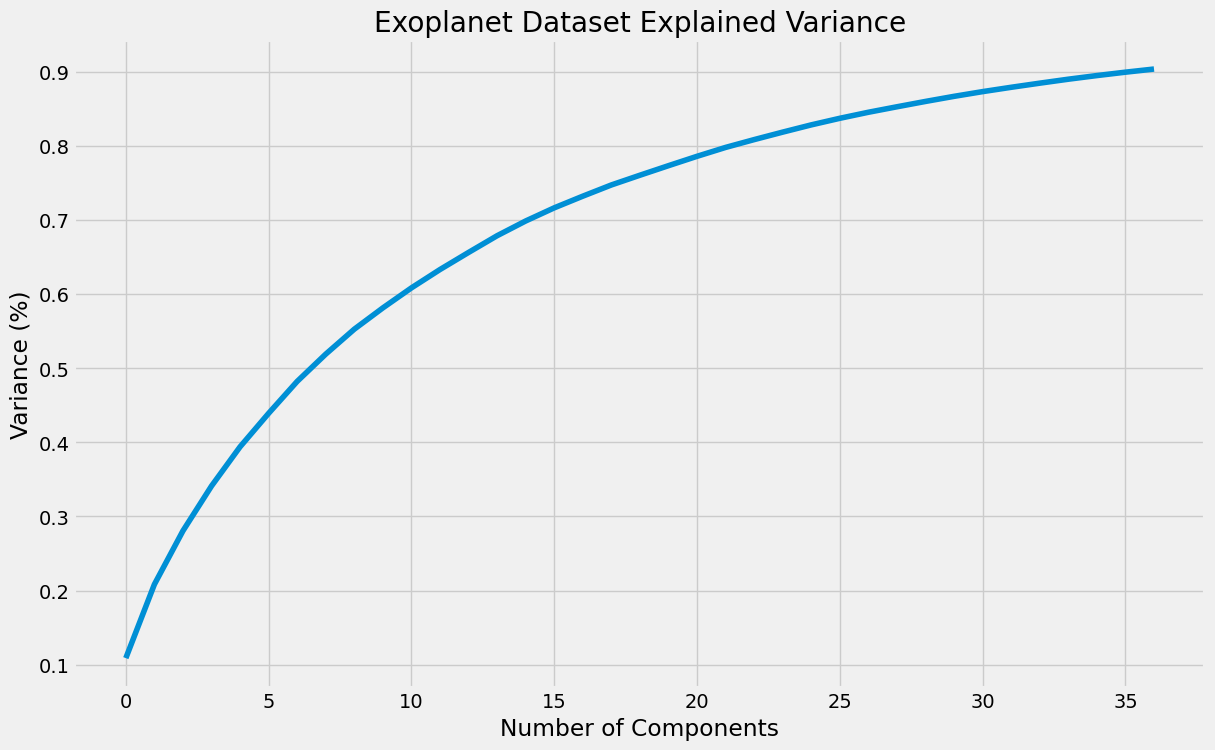

In [15]:
"""
This plot tells us that selecting 35 components we can preserve something around 98.8% or 99% 
of the total variance of the data. It makes sense, we’ll not use 100% of our variance,
because it denotes all components, and we want only the principal ones.
"""

#Apply PCA with n_componenets
pca = PCA(n_components=37)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

RangeIndex(start=0, stop=37, step=1)

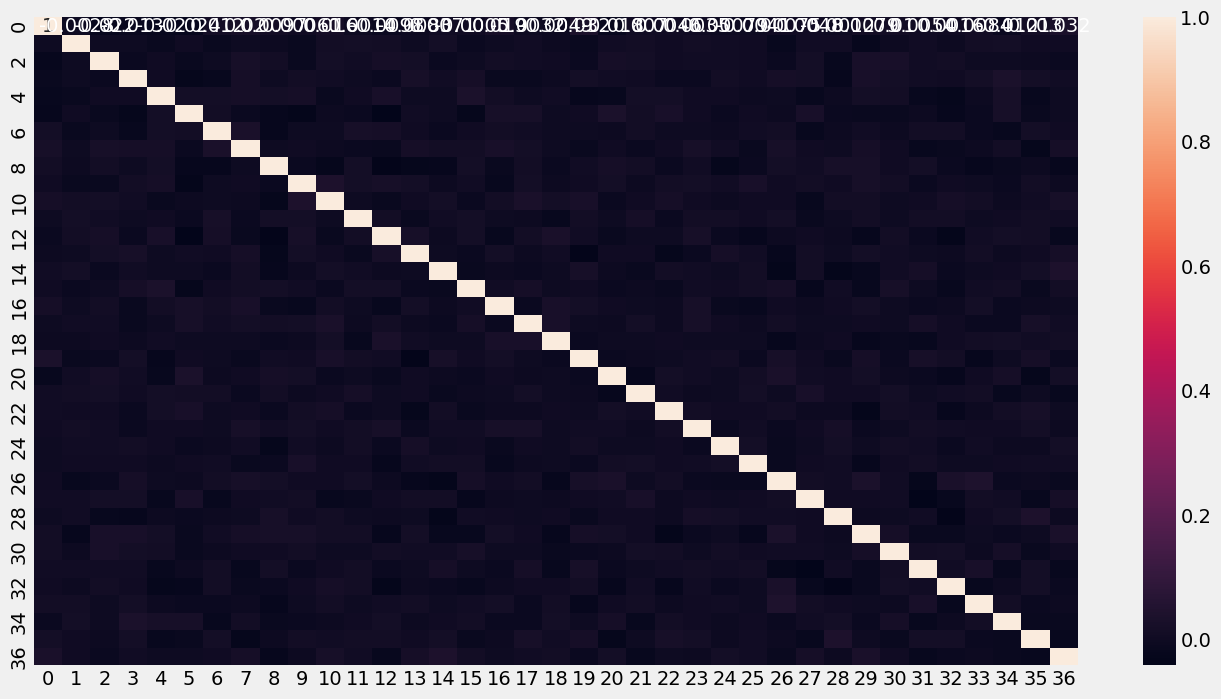

In [16]:
df = pd.DataFrame.from_records(x_train)     
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
df.columns

In [17]:
#Resampling as the data is highly unbalanced.
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 



In [18]:
sm = SMOTE(random_state=27, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel()) 

In [19]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


In [20]:
#Artificial Neural Network
import tensorflow
tensorflow.random.set_seed(101)
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library

2024-05-30 04:12:39.493260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [22]:
classifier = KerasClassifier(build_fn = build_classifier, epochs = 40)
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

2024-05-30 04:12:45.782939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 04:12:45.795933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 04:12:45.807602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30

Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
253/253 [==============================] - 4s 4ms/step - loss: 0.3876 - accuracy: 0.9238
Epoch 2/40
253/253 [==============================] - 4s 4ms/step - loss: 0.3392 - accuracy: 0.8291
Epoch 2/40
253/253 [==============================] - 4s 4ms/step - loss: 0.3212 - accuracy: 0.9028
Epoch 2/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0970 - accuracy: 0.9931
Epoch 3/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0348 - accuracy: 0.9967
Epoch 3/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0300 - accuracy: 0.9978
Epoch 3/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0441 - accuracy: 0.9996
Epoch 4/40
Epoch 4/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0063 - accuracy: 0.9998
Epoch 4/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0077 - accuracy: 0.9996
Epoch 4/40
253/253 [=========================

### Additions

In [25]:
classifier.fit(x_train, y_train)

Epoch 1/40
159/159 [==============================] - 2s 5ms/step - loss: 0.5336 - accuracy: 0.9921
Epoch 2/40
159/159 [==============================] - 1s 5ms/step - loss: 0.1173 - accuracy: 0.9927
Epoch 3/40
159/159 [==============================] - 1s 6ms/step - loss: 0.0340 - accuracy: 0.9927
Epoch 4/40
159/159 [==============================] - 1s 6ms/step - loss: 0.0182 - accuracy: 0.9927
Epoch 5/40
159/159 [==============================] - 1s 5ms/step - loss: 0.0124 - accuracy: 0.9927
Epoch 6/40
159/159 [==============================] - 1s 5ms/step - loss: 0.0103 - accuracy: 0.9927
Epoch 7/40
159/159 [==============================] - 1s 5ms/step - loss: 0.0092 - accuracy: 0.9927
Epoch 8/40
159/159 [==============================] - 1s 6ms/step - loss: 0.0086 - accuracy: 0.9927
Epoch 9/40
159/159 [==============================] - 1s 7ms/step - loss: 0.0082 - accuracy: 0.9927
Epoch 10/40
159/159 [==============================] - 1s 6ms/step - loss: 0.0078 - accuracy: 0.9927

'              precision    recall  f1-score   support\n\n           0       0.99      0.97      0.98       565\n           1       0.00      0.00      0.00         5\n\n    accuracy                           0.96       570\n   macro avg       0.50      0.49      0.49       570\nweighted avg       0.98      0.96      0.97       570\n'

In [27]:
pred_ann = classifier.predict(x_test)
print(classification_report(y_test, pred_ann))

18/18 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       565
           1       0.00      0.00      0.00         5

    accuracy                           0.96       570
   macro avg       0.50      0.49      0.49       570
weighted avg       0.98      0.96      0.97       570



In [32]:
from sklearn.metrics import roc_curve, auc

18/18 [==============================] - 0s 9ms/step


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

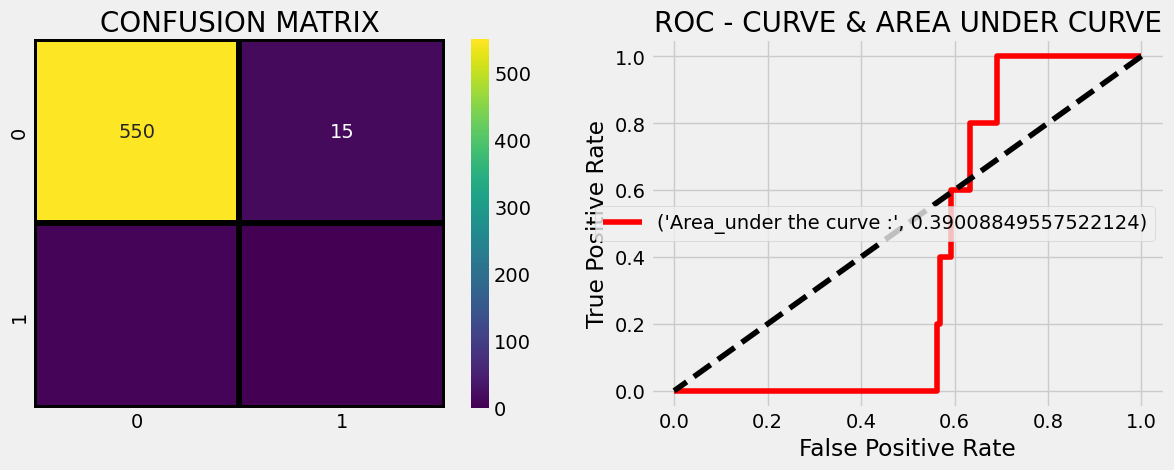

In [33]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,pred_ann),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = classifier.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test.to_numpy(),predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)